# [Wind Turbine Scada Dataset](https://www.kaggle.com/berkerisen/wind-turbine-scada-dataset)

### Context
 In Wind Turbines, Scada Systems measure and save data's like wind speed, wind direction, generated power etc. for 10 minutes intervals. This file was taken from a wind turbine's scada system that is working and generating power in Turkey.

### Content
 The data's in the file are:

* Date/Time (for 10 minutes intervals)
* LV ActivePower (kW): The power generated by the turbine for that moment
* Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)
* Theoretical_Power_Curve (KWh): The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer
* Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import ppscore as pps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import ExtraTreesRegressor
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('T1.csv')
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


From the first glance, I'd say that the wind speed is the key feature here; because it's the only feature that is directly related to the power generated by the turbine, wind direction shouldn't have a direct effect on the power generated by the turbine as the turbine turns to the wind direction automaticly, there might be a correlation between the wind direction though, but I don't think it's a direct one.

Theoretical power curve is the power values that the turbine generates with that wind speed which is given by the turbine manufacturer, so it's not a real data, it's a theoretical one, it should be proportional to the power really generated by the turbine and the wind speed.

The date/time feature is not a numerical feature, it's a categorical one, so it should be converted to a numerical feature before using it in the model. Then it'd make sense that it's related to the power generated by the turbine, because the power generated by the turbine might be affected by the time of the day, the day of the week, the month of the year, the season of the year, the year itself, etc. For example, there might be time of the day or the season of the year that the wind speed is usually higher, so the power generated by the turbine would be higher too.

The data is overall understandable and should be easy to use.

In [4]:
#let's make the Date/Time column a datetime object
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.tail()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913
50529,2018-12-31 23:50:00,2820.466064,9.979332,2779.184096,82.274620


In [5]:
len(df)/(6*24)

350.90277777777777

Appearently, the farm was off for the equivalent of 14 days, so the data is not continuous, it's missing 14 days, these days may be holidays, maintenance days, or something else, this shouldn't be a problem, but it's something to keep in mind.

In [6]:
#add a column for season
df['Season'] = df['Date/Time'].apply(lambda x: 'Winter' if x <= pd.Timestamp('2018-03-20') 
                                     else 'Spring' if x <= pd.Timestamp('2018-06-21') 
                                     else 'Summer' if x <= pd.Timestamp('2018-09-22') 
                                     else 'Fall' if x <= pd.Timestamp('2018-12-21') 
                                     else 'Winter').astype('category')

df.sample()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Season
26626,2018-10-07 03:10:00,0.0,1.628722,0.0,301.558105,Fall


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date/Time                      50530 non-null  datetime64[ns]
 1   LV ActivePower (kW)            50530 non-null  float64       
 2   Wind Speed (m/s)               50530 non-null  float64       
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64       
 4   Wind Direction (°)             50530 non-null  float64       
 5   Season                         50530 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(4)
memory usage: 2.0 MB


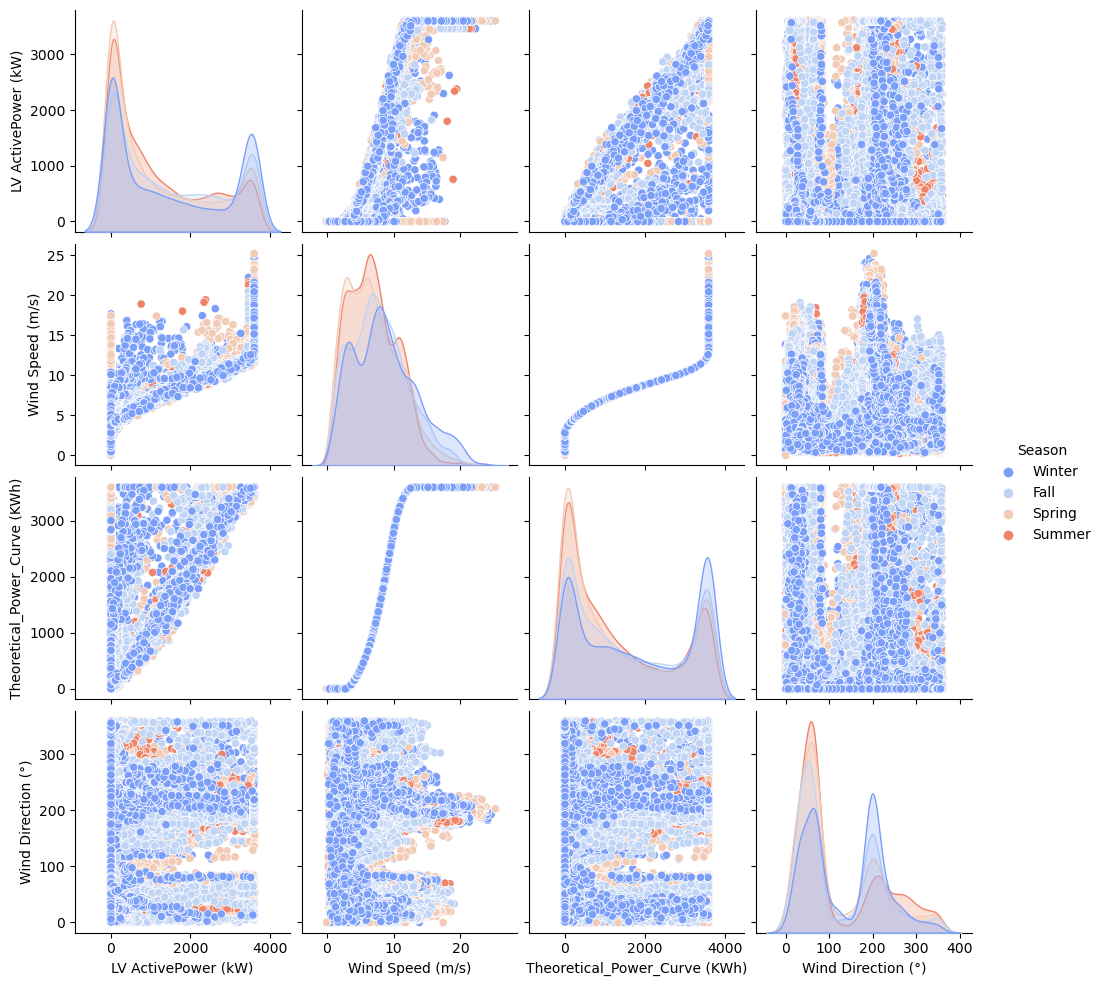

In [8]:
sns.pairplot(df, hue='Season', hue_order=['Winter', 'Fall', 'Spring', 'Summer'], palette='coolwarm');

Let's check for correlations between the features:

In [9]:
#sort the data by date/time
df.sort_values(by='Date/Time', inplace=True)
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Season
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,Winter
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,Winter
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,Winter
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,Winter
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,Winter


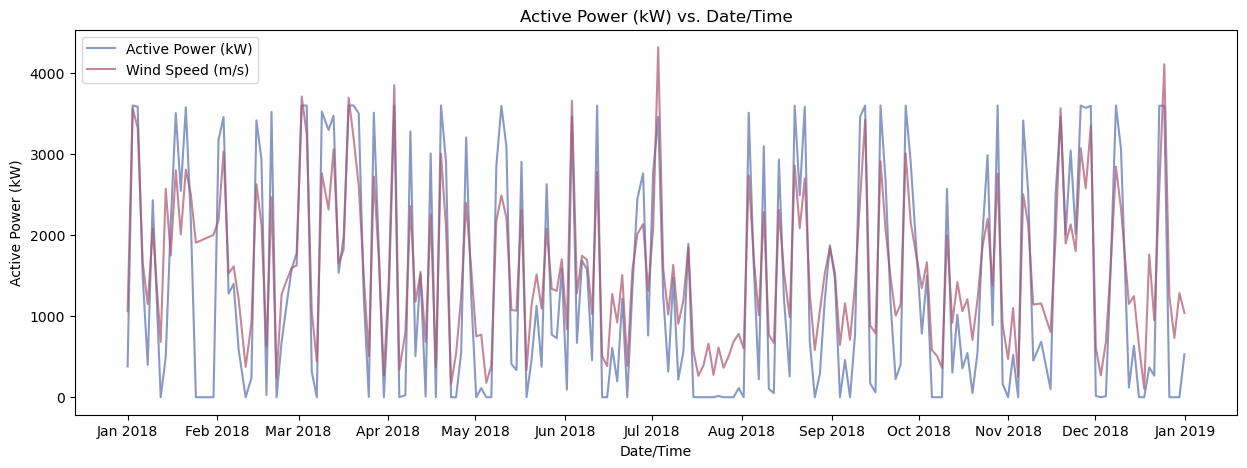

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df['Date/Time'][::250], df['LV ActivePower (kW)'][::250], color='#556eac', label='Active Power (kW)', alpha=0.7)
ax.plot(df['Date/Time'][::250], df['Wind Speed (m/s)'][::250]*200, color='#ac556e', label='Wind Speed (m/s)', alpha=0.7)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.title('Active Power (kW) vs. Date/Time')
plt.xlabel('Date/Time')
plt.ylabel('Active Power (kW)')
plt.legend()
plt.show()

The relationship between the wind speed and the power generated by the turbine should be obvious by now, let's see the correlation between the other features:

In [11]:
pps_df = pps.matrix(df).round(2) # type: ignore

In [12]:
pps_df.query("(case != 'predict_itself') & ppscore > 0").sort_values(by=['ppscore'], ascending=False)[['x', 'y', 'ppscore']]

,x,y,ppscore
5,Date/Time,Season,1.00
15,Wind Speed (m/s),Theoretical_Power_Curve (KWh),1.00
20,Theoretical_Power_Curve (KWh),Wind Speed (m/s),0.91
9,LV ActivePower (kW),Theoretical_Power_Curve (KWh),0.82
13,Wind Speed (m/s),LV ActivePower (kW),0.81
19,Theoretical_Power_Curve (KWh),LV ActivePower (kW),0.81
8,LV ActivePower (kW),Wind Speed (m/s),0.73
1,Date/Time,LV ActivePower (kW),0.71
4,Date/Time,Wind Direction (°),0.71
3,Date/Time,Theoretical_Power_Curve (KWh),0.70


$ \rightarrow $ Season is 100% correlated with Date/Time, this is obvious, because the season is determined by the date in the first place. Date time is also correlated with all the other features, and this makes sense, hence we can use date/time to determine the other features, but not vice versa.

$ \rightarrow $ Wind Speed $(m/s)$ and Theoretical_Power_Curve $(KWh)$ are 100% correlated, this is obvious too, because the theoretical power curve is the power values that the turbine generates with that wind speed which is given by the turbine manufacturer. It's worth mentioning that the theoretical power curve is not a real data, it's a theoretical one, it's also capped, that means that we may easily fit a curve to these data points to get the theoretical power curve.

$ \rightarrow $ The previously mentioned curve can be used to determine the wind speed and vice versa, and since Wind Speed $(m/s)$ and LV ActivePower $(kW)$ are correlated, it's sensible to think that the three of them are strongly correlated and may be use interchangeably.



$ \blacktriangleright $ Since all the features are correlated somehow, and are not many, we can use all of them in the model, but we should keep in mind that some of them are not real data, they are theoretical ones, and some of them are not numerical features, they are categorical ones, so they should be converted to numerical features before using them in the model.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Date/Time', 'LV ActivePower (kW)'], axis=1), df['LV ActivePower (kW)'], test_size=0.2, random_state=42)

In [14]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train[['Season']])
cols = ['winter', 'spring', 'summer', 'fall']
X_train_enc = pd.DataFrame(enc.transform(X_train[['Season']]).toarray(), columns=cols, index=X_train.index)
X_test_enc = pd.DataFrame(enc.transform(X_test[['Season']]).toarray(), columns=cols, index=X_test.index)
X_train = pd.concat([X_train, X_train_enc], axis=1)
X_test = pd.concat([X_test, X_test_enc], axis=1)
X_train.drop('Season', axis=1, inplace=True)
X_test.drop('Season', axis=1, inplace=True)

In [15]:
model = ExtraTreesRegressor(random_state=42)
model.fit(X_train, y_train)
display(model.score(X_train, y_train))
display(model.score(X_test, y_test))
display(dict(zip(X_train.columns, model.feature_importances_.round(3))))

0.9999999999999998

0.9331752303367596

{'Wind Speed (m/s)': 0.22,
 'Theoretical_Power_Curve (KWh)': 0.723,
 'Wind Direction (°)': 0.047,
 'winter': 0.0,
 'spring': 0.001,
 'summer': 0.0,
 'fall': 0.009}

This model should help us to predict the power generated by the turbine for a given wind speed, wind direction, date/time, etc. This can become handy in many situations, for example, we want to monitor if there's any energy being stolen from the farm, we can use this model to predict the power that should be generated by the turbine for a given set of parameters and compare it to the real power generated by the turbine, if there's a big difference, then there's a problem, and we should investigate it.

A thing to notice here is that Wind Direction has some significance in the model, but it's definitely an indirect relationship, probably the model uses it to determine the chain: $season \rightarrow Wind Speed \rightarrow LV ActivePower $